In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import gym

from tqdm.auto import tqdm, trange
import time

In [3]:
from tiles3 import IHT, tiles

In [4]:
iht = IHT(1024)

print(tiles(iht, 8, [3.6, 7.2]))
print(tiles(iht, 8, [3.7, 7.2]))
print(tiles(iht, 8, [4.8, 7.5]))
print(tiles(iht, 8, [4.2, 7.35]))

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 8, 4, 5, 6, 7]
[9, 10, 11, 12, 13, 14, 15, 16]
[9, 10, 17, 8, 4, 5, 6, 18]


In [5]:
max_size = 4096
iht=IHT(max_size)

x, xdot = -0.5, 0.0
a = 0
print(tiles(iht,8,[8*x/(0.5+1.2),8*xdot/(0.07+0.07)],[a]))
a = 1
print(tiles(iht,8,[8*x/(0.5+1.2),8*xdot/(0.07+0.07)],[a]))

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 14, 15]


In [6]:
def scale(s):
    return [10*s[0]/(0.6+1.2),10*s[1]/(0.07+0.07)]

In [31]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 10_000
env.reset()
for step in range(100):
    env.render()
    a = 2#env.action_space.sample()
    observation, reward, done, info = env.step(a)
    
    if step % 10 == 0:
        print(observation, a, reward)
        print(tiles(iht, 8, scale(observation), [a]))
    time.sleep(0.02)
env.close()

[-4.21934410e-01  2.51079928e-04] 2 -1.0
[16, 17, 18, 19, 20, 21, 22, 23]
[-0.40685707  0.0023844 ] 2 -1.0
[16, 17, 18, 19, 20, 24, 22, 23]
[-0.378329    0.00293807] 2 -1.0
[16, 25, 26, 19, 20, 24, 22, 23]
[-0.35497385  0.00159849] 2 -1.0
[27, 25, 26, 19, 20, 21, 22, 23]
[-0.35162    -0.00074293] 2 -1.0
[28, 25, 26, 19, 20, 21, 22, 23]
[-0.37036293 -0.00262137] 2 -1.0
[29, 25, 26, 30, 20, 21, 22, 23]
[-0.3993815  -0.00283065] 2 -1.0
[29, 17, 26, 30, 20, 21, 22, 23]
[-0.4198797  -0.00118201] 2 -1.0
[29, 17, 18, 19, 20, 21, 22, 23]
[-0.4182598   0.00125728] 2 -1.0
[16, 17, 18, 19, 20, 21, 22, 23]
[-0.39560517  0.00285585] 2 -1.0
[16, 17, 26, 19, 20, 24, 22, 23]


In [9]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [10]:
w = np.random.randn(max_size)

x = tiles(iht, 8, scale(observation), [0])

In [11]:
w[x]

array([ 0.66627691, -0.30541681,  2.2309895 ,  0.74581261, -0.25962788,
        0.96454013,  0.39791176, -2.56982517])

In [12]:
def q_hat(s,a,w):
    x = tiles(iht, 8, scale(s), [a])
    return w[x].sum()

In [13]:
q_hat(observation, 0, w), q_hat(observation, 1, w), q_hat(observation, 2, w)

(1.870661073301286, 3.69859258428407, 1.0792313598132577)

## Episodic semi-gradient Sarsa 

In [14]:
def greedy(s, w):
    return max(range(3), key=lambda a: q_hat(s, a, w))

def eps_greedy(s, w, eps=0.1):
    if random.random() < eps:
        return random.randint(0,2)
    else:
        return greedy(s, w)

In [32]:
def run_sarsa(n_episodes=10, alpha=0.2, gamma=1., eps=0.1):
    env = gym.make('MountainCar-v0')
    max_steps = env._max_episode_steps = 10_000
    steps_per_episode = np.zeros(n_episodes, )
    
    alpha /= 8
    w = np.zeros((max_size))
    pbar = trange(n_episodes, leave=False)
    for e in pbar:
        
        s = env.reset()
        a = eps_greedy(s, w, eps)
        done = False
        
        for step in range(max_steps):
            idx = tiles(iht, 8, scale(s), [a])
            sp, r, done, info = env.step(a)
            if done:
                w[idx] += alpha * (r - q_hat(s,a,w))
                steps_per_episode[e] = step+1
                break
            ap = eps_greedy(s, w, eps/(e+1))
            w[idx] += alpha * (r + gamma*q_hat(sp,ap,w) - q_hat(s,a,w))
            s, a = sp, ap
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

  0%|          | 0/500 [00:00<?, ?it/s]

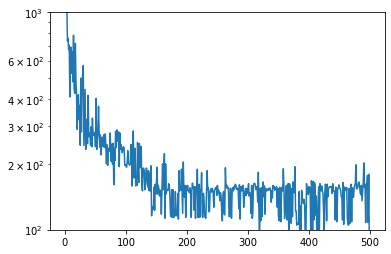

In [33]:
steps_per_episode, w = run_sarsa(500)

plt.plot(steps_per_episode)
plt.ylim([100, 1000])
plt.yscale("log")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

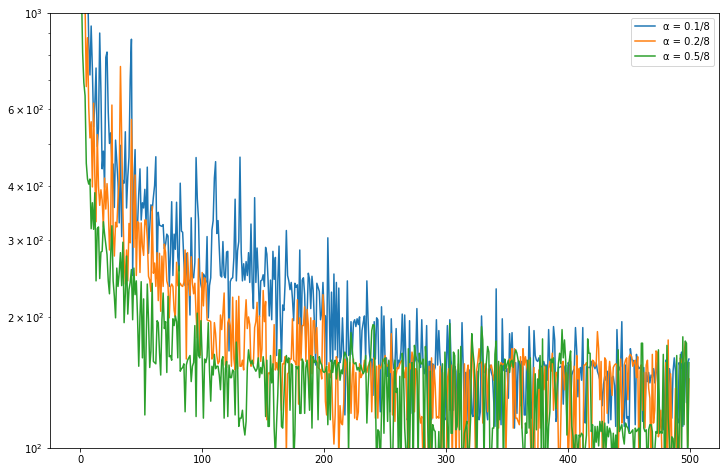

In [17]:
n_runs = 10
n_episodes = 500
fig = plt.figure(figsize=(12, 8))

for alpha in [0.1, 0.2, 0.5]:
    avg_steps_per_episode = np.zeros(n_episodes)
    for i in range(1,n_runs+1):
        steps_per_episode, w = run_sarsa(n_episodes, alpha=alpha)
        avg_steps_per_episode += (steps_per_episode - avg_steps_per_episode)/i
    
    plt.plot(steps_per_episode, label=f"α = {alpha}/8")
    
plt.ylim([100, 1000])
plt.yscale("log")
plt.legend(loc='upper right')
plt.show()

In [36]:
env = gym.make('MountainCar-v0')
s = env.reset()
done = False
total_reward = 0
while not done:
    env.render()
    # greedy policy
    a = max(range(3), key=lambda a: q_hat(s,a,w))
    s, r, done, info = env.step(a)
    total_reward += r
    time.sleep(0.02)
env.close()
print("Total reward =", total_reward)

Total reward = -91.0


### Value function landscape

In [ ]:
x = np.linspace(-1.2, 0.6, 100)
xdot = np.linspace(-0.07, 0.07, 100)

In [29]:
def run_qlearning(n_episodes=10, alpha=0.2, gamma=1., eps=0.05):
    max_steps = 100_000
    steps_per_episode = np.zeros(n_episodes, )
    
    alpha /= 8
    w = np.zeros((max_size))
    pbar = trange(n_episodes)
    for e in pbar:
        
        s = env.reset()
        a = env.action_space.sample()
        done = False
        
        for step in range(max_steps):
            idx = tiles(iht, 8, scale(s), [a])
            sp, r, done, info = env.step(a)
            if done:
                w[idx] += alpha * (r - q_hat(s,a,w))
                steps_per_episode[e] = step+1
                break
            ap = eps_greedy(s, w)
            w[idx] += alpha * (r + gamma*max([q_hat(sp, a_, w) for a_ in range(3)]) - q_hat(s,a,w))
            s, a = sp, ap
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

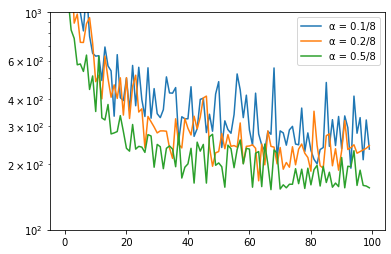

In [31]:
fig = plt.figure()

for alpha in [0.1, 0.2, 0.5]:
    steps_per_episode, w = run_qlearning(100, alpha=alpha)
    plt.plot(steps_per_episode, label=f"α = {alpha}/8")
    
plt.ylim([100, 1000])
plt.yscale("log")
plt.legend(loc='upper right')
plt.show()

## Episodic semi-gradient n-step Sarsa

In [121]:
def run_nsarsa(n=1, n_episodes=10, alpha=0.2, gamma=1., eps=0.1):
    max_steps = 100_000
    steps_per_episode = np.zeros(n_episodes, )
    
    [S, A, R] = np.zeros((n+1,2)), np.zeros(n+1), np.zeros(n+1)
    alpha /= 8
    w = np.zeros((max_size))
    pbar = trange(n_episodes, leave=False)
    for e in pbar:
        
        s = env.reset()
        a = env.action_space.sample()
        S[0], A[0] = s, a
        T = float("inf")
        
        for t in range(max_steps):
            if t < T:
                sp, r, done, info = env.step(a)
                R[(t+1)%(n+1)] = r
                S[(t+1)%(n+1)] = sp

                if done:
                    T = t + 1
                    steps_per_episode[e] = T
                else:
                    ap = eps_greedy(s, w, eps/(e+1))
                    A[(t+1)%(n+1)] = ap
            tau = t-n+1
            if tau >= 0:
                G = sum(
                    [gamma**(i-tau-1)*R[i%(n+1)] for i in range(tau+1,min(tau+n, T)+1)]
                )
                if tau+n < T:
                    G += gamma**n * q_hat(S[(tau+n)%(n+1)], A[(tau+n)%(n+1)], w)
                
                idx = tiles(iht, 8, scale(S[tau%(n+1)]), [A[tau%(n+1)]])
                w[idx] += alpha * (G - q_hat(S[tau%(n+1)],A[tau%(n+1)],w))
                s, a = sp, ap
            if tau == T-1:
                break
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

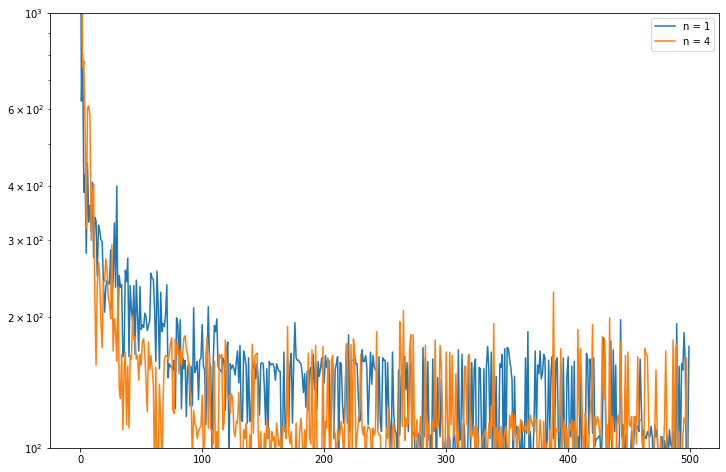

In [136]:
n_episodes = 500

fig = plt.figure(figsize=(12, 8))

for n, alpha in zip([1,4], [0.5, 0.3]):
    avg_steps_per_episode = np.zeros(n_episodes)
    for i in range(1,11):
        steps_per_episode, w = run_nsarsa(n=n, n_episodes=n_episodes, alpha=alpha)
        avg_steps_per_episode += (steps_per_episode - avg_steps_per_episode)/i
    plt.plot(avg_steps_per_episode, label=f"n = {n}")
    
plt.ylim([100, 1000])
plt.yscale("log")
plt.legend(loc='upper right')
plt.show()

### Policy visualization

In [139]:
s = env.reset()
done = False
total_reward = 0
while not done:
    env.render()
    # greedy policy
    a = max(range(3), key=lambda a: q_hat(s,a,w))
    s, r, done, info = env.step(a)
    total_reward += r
    time.sleep(0.01)
env.close()
print("Total reward =", total_reward)

Total reward = -105.0


## Sarsa(λ)

In [19]:
def run_sarsal(n_episodes=10, lmda=0.96, alpha=.1, gamma=1., eps=0.1, replacing_traces=False):
    env = gym.make('MountainCar-v0')
    max_steps = env._max_episode_steps = 10_000
        
    steps_per_episode = np.zeros(n_episodes, )
    
    alpha /= 8
    w = np.zeros((max_size))
    pbar = trange(n_episodes, leave=False)
    for e in pbar:
        
        s = env.reset()
        a = eps_greedy(s, w, eps)
        done = False
        z = np.zeros_like(w)
        
        for step in range(max_steps):
            idx = tiles(iht, 8, scale(s), [a])
            sp, r, done, info = env.step(a)
            delta = r - q_hat(s,a,w)
            if replacing_traces:
                z[idx] = 1.
            else:
                z[idx] += 1. # accummulating traces
            if done:
                w[idx] += alpha * delta * z[idx]
                steps_per_episode[e] = step+1
                break
            ap = eps_greedy(s, w, eps/(e+1))
            delta += gamma*q_hat(sp, ap, w)
            w[idx] += alpha * delta * z[idx]
            z *= gamma*lmda
            s, a = sp, ap
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

  0%|          | 0/100 [00:00<?, ?it/s]

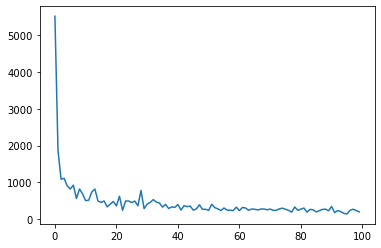

In [39]:
spe, w = run_sarsal(100, alpha=0.1)
plt.plot(spe)

In [25]:
def run_true_sarsal(n_episodes=10, lmda=0.96, alpha=.1, gamma=1., eps=0.1, replacing_traces=False):
    env = gym.make('MountainCar-v0')
    max_steps = env._max_episode_steps = 10_000
        
    steps_per_episode = np.zeros(n_episodes, )
    
    alpha /= 8
    w = np.zeros((max_size))
    pbar = trange(n_episodes, leave=False)
    for e in pbar:
        
        s = env.reset()
        a = eps_greedy(s, w, eps)
        done = False
        z = np.zeros_like(w)
        q_old = 0
        for step in range(max_steps):
            idx = tiles(iht, 8, scale(s), [a])
            sp, r, done, info = env.step(a)
            ap = eps_greedy(sp, w, eps/(e+1))
            q = q_hat(s,a,w)
            qp = q_hat(sp,ap,w)
            delta = r + gamma*qp - q
            x = np.zeros_like(w)
            x[idx] = 1.
            z = gamma*lmda*z + (1 - alpha*gamma*lmda*z[idx].sum())*x
            w = w + alpha*(delta + q - q_old)*z - alpha*(q-q_old)*x
            q_old = q
            s, a = sp, ap
            if done:
                steps_per_episode[e] = step+1
                break
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

  0%|          | 0/100 [00:00<?, ?it/s]

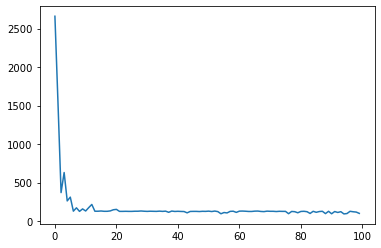

In [26]:
spe, w = run_true_sarsal(100)
plt.plot(spe)

In [27]:
from functools import partial

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

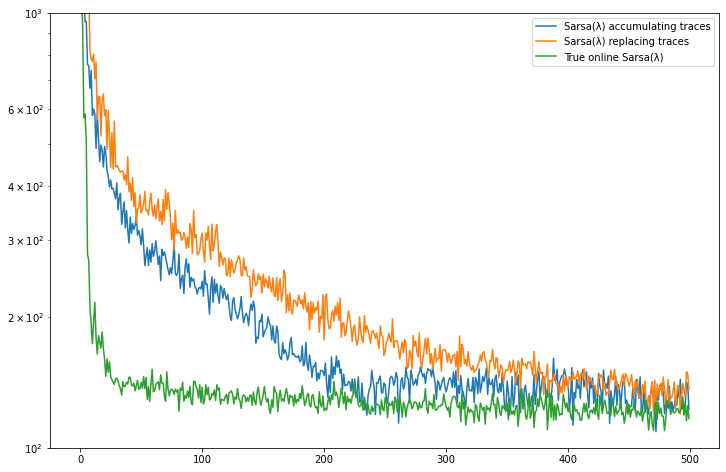

In [29]:
n_episodes = 500

fig = plt.figure(figsize=(12, 8))

run_sarsal_rt = partial(run_sarsal, replacing_traces=True)
for func, alg, alpha in zip(
    [run_sarsal, run_sarsal_rt, run_true_sarsal],
    ["Sarsa(λ) accumulating traces", 
     "Sarsa(λ) replacing traces", 
     "True online Sarsa(λ)"],
    [0.1, 0.1, 0.1]
):
    avg_steps_per_episode = np.zeros(n_episodes)
    for i in range(1,11):
        steps_per_episode, w = func(lmda=0.96, n_episodes=n_episodes, alpha=alpha)
        avg_steps_per_episode += (steps_per_episode - avg_steps_per_episode)/i
    plt.plot(avg_steps_per_episode, label=alg)
    
plt.ylim([100, 1000])
plt.yscale("log")
plt.legend(loc='upper right')
plt.show()